# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
        * [1.2.3. Line ratio constraints](#chapter1_2_3)
    * [1.3. Setting up the plotting parameters](#chapter1_3)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)

<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
# book-keeping variables (optional; for this box only)
#volume = '/Users/caroline/Documents/ARI-Heidelberg/Q3D/DATA/makani_SDSS/'
volume = '' # base directory
gal = 'makanisdss' # prefix label for output files

# Input files
infile = volume+'path/makanisdss.fits' # path + name of your input cube
stellartemplates = volume+'path/makani_stelmod.npy'

# Output directories/files
outdir = volume+'path/makanisdss/' # path + name of directory for saving the output files
path_to_npy_file = outdir # path for initproc.npy
logfile = outdir+gal+'_fitlog.txt'

Some general information about your cube:

In [3]:
ncols = 1
nrows = 1
fitrange = [3814, 9201] #in Angstrom

if not os.path.isfile(infile): print('Data cube not found.')

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [4]:
lines0 = ['[NeV]3345', '[NeV]3426', 'HeII4686']
lines1 = ['[OII]3726', '[OII]3729',
          '[NeIII]3869', '[NeIII]3967',
          '[OIII]4959', '[OIII]5007',
          'Hgamma', 'Hdelta', 'Hepsilon']
lines = lines0 + lines1

How many components do you want to be fitted to the emission lines?

In [5]:
maxncomp = 2

In [6]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines0:
    linetie[i] = '[NeV]3426'
    ncomp[i] = np.full((ncols, nrows), 1)
    zinit_gas[i] = np.full((ncols, nrows,  maxncomp), 0.45666)
    siginit_gas[i] = np.full(maxncomp, 100)
for i in lines1:
    linetie[i] = '[OII]3729'
    ncomp[i] = np.full((ncols, nrows), maxncomp)
    zinit_gas[i] = np.full((ncols, nrows, maxncomp), 0.45915)
    zinit_gas[i][:, :, 1] = 0.45737
    siginit_gas[i] = np.full(maxncomp, 100)

zinit_stars = np.full((ncols, nrows), 0.459)
 
siglim_gas = np.ndarray(2)
siglim_gas[:] = [5, 1500]

#### 1.2.3. Line ratio constraints <a class="anchor" id="chapter1_2_3"></a>
`line1`, `line2`, and `comp` are required. `value` is the initial value of `line1`/`line2`, and `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) The ratio can also be `fixed`.

In [ ]:
# Required columns:
line1 = ['[OII]3729', '[OII]3729']
line2 = ['[OII]3726', '[OII]3726']
comp = np.array([0, 1], dtype=np.int32)

# Optional columns:
value = [1.2, 1.2]
fixed = [True, True]
# lower = []
# upper = []

# Write table
from astropy.table import QTable
lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [7]:
argspltlin1 = {'nx': 3,
               'ny': 2,
               'line': ['[NeV]3426', '[OII]3726', '[NeIII]3869', 'Hgamma', 'HeII4686', '[OIII]4959'],
               'size': [250., 250., 250., 250., 250., 400.]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [8]:
initproc = { \
            # Required pars
            'fitran': fitrange,
            'fluxunits': 1e-17,  # erg/s/cm^2/arcsec^2
            'infile': infile,
            'label': gal,
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'Makani',
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.459,
            # Optional pars
            'datext': 0,
            'varext': 1,
            'dqext': 2,
            'argscheckcomp': {'sigcut': 2},
            'argscontfit': {'siginit_stars': 50,
                            'uselog': 1,
                            'refit': 1},
            'argsreadcube': {'waveunit_in': 'Angstrom',
                             'waveunit_out': 'Angstrom',
                             'fluxunit_in': 'erg/s/cm2/Angstrom/sr',
                             'fluxunit_out': 'erg/s/cm2/Angstrom/sr'},
            'argslinelist': {'vacuum': False,
                             'waveunit': 'Angstrom'},
            'argscontplot': {'xstyle':'lin',
                             'ystyle':'lin',
                             'waveunit_in': 'Angstrom',
                             'waveunit_out': 'Angstrom',
                             'fluxunit_in':'flambda',
                             'fluxunit_out':'flambda',
                             'mode':'dark'},
            'argsinitpar': {'siglim': siglim_gas,
                            'lineratio': lineratio},
            'startempfile': stellartemplates,
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'fcncontfit': 'ppxf',
            'maskwidths_def': 2000,
            'emlsigcut': 2,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': 50,
            'nocvdf': 1
        }

If you want to run q3dfit in batch mode, run this cell, which saves initproc to an "npy" file. In your python command line, read in that "npy" file with <pre><code> initproc = np.load('path/to/the/npy/file/initproc.npy', allow_pickle=True) </code></pre> and then run q3dfit with <pre><code> q3df(initproc[()],cols=cols,rows=rows) </code></pre>

In [ ]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [9]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [10]:
q3df(initproc, quiet=False)

local variable 'CUNIT' referenced before assignment
... Continuing anyway ...
FITLOOP: First call to FITSPEC
 Best Fit:       Vel     sigma
 comp.  0:        59       163
chi2/DOF: 0.8637; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  1 / 1
Templates weights:
      9.65
FITSPEC: Continuum fit took 0.0 s.
[[Model]]
    ((((((((((((((((((((Model(manygauss, prefix='lbNeVrb3345_0_') + Model(manygauss, prefix='lbNeVrb3426_0_')) + Model(manygauss, prefix='HeII4686_0_')) + Model(manygauss, prefix='lbOIIrb3726_0_')) + Model(manygauss, prefix='lbOIIrb3726_1_')) + Model(manygauss, prefix='lbOIIrb3729_0_')) + Model(manygauss, prefix='lbOIIrb3729_1_')) + Model(manygauss, prefix='lbNeIIIrb3869_0_')) + Model(manygauss, prefix='lbNeIIIrb3869_1_')) + Model(manygauss, prefix='lbNeIIIrb3967_0_')) + Model(manygauss, prefix='lbNeIIIrb3967_1_')) + Model(manygauss, prefix='lbOIIIrb4959_0_')) + Model(manygauss, prefix='lb

[[Model]]
    ((((((((((((((((((((Model(manygauss, prefix='lbNeVrb3345_0_') + Model(manygauss, prefix='lbNeVrb3426_0_')) + Model(manygauss, prefix='HeII4686_0_')) + Model(manygauss, prefix='lbOIIrb3726_0_')) + Model(manygauss, prefix='lbOIIrb3726_1_')) + Model(manygauss, prefix='lbOIIrb3729_0_')) + Model(manygauss, prefix='lbOIIrb3729_1_')) + Model(manygauss, prefix='lbNeIIIrb3869_0_')) + Model(manygauss, prefix='lbNeIIIrb3869_1_')) + Model(manygauss, prefix='lbNeIIIrb3967_0_')) + Model(manygauss, prefix='lbNeIIIrb3967_1_')) + Model(manygauss, prefix='lbOIIIrb4959_0_')) + Model(manygauss, prefix='lbOIIIrb4959_1_')) + Model(manygauss, prefix='lbOIIIrb5007_0_')) + Model(manygauss, prefix='lbOIIIrb5007_1_')) + Model(manygauss, prefix='Hgamma_0_')) + Model(manygauss, prefix='Hgamma_1_')) + Model(manygauss, prefix='Hdelta_0_')) + Model(manygauss, prefix='Hdelta_1_')) + Model(manygauss, prefix='Hepsilon_0_')) + Model(manygauss, prefix='Hepsilon_1_'))
[[Fit Statistics]]
    # fitting method  

[[Model]]
    (((((((((((((((((Model(manygauss, prefix='lbOIIrb3726_0_') + Model(manygauss, prefix='lbOIIrb3726_1_')) + Model(manygauss, prefix='lbOIIrb3729_0_')) + Model(manygauss, prefix='lbOIIrb3729_1_')) + Model(manygauss, prefix='lbNeIIIrb3869_0_')) + Model(manygauss, prefix='lbNeIIIrb3869_1_')) + Model(manygauss, prefix='lbNeIIIrb3967_0_')) + Model(manygauss, prefix='lbNeIIIrb3967_1_')) + Model(manygauss, prefix='lbOIIIrb4959_0_')) + Model(manygauss, prefix='lbOIIIrb4959_1_')) + Model(manygauss, prefix='lbOIIIrb5007_0_')) + Model(manygauss, prefix='lbOIIIrb5007_1_')) + Model(manygauss, prefix='Hgamma_0_')) + Model(manygauss, prefix='Hgamma_1_')) + Model(manygauss, prefix='Hdelta_0_')) + Model(manygauss, prefix='Hdelta_1_')) + Model(manygauss, prefix='Hepsilon_0_')) + Model(manygauss, prefix='Hepsilon_1_'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 3825
    # variables        = 18
    chi-square         = 13853.1

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Inline plotting:

CUBE: WMAP extension does not exist.
local variable 'CUNIT' referenced before assignment
... Continuing anyway ...


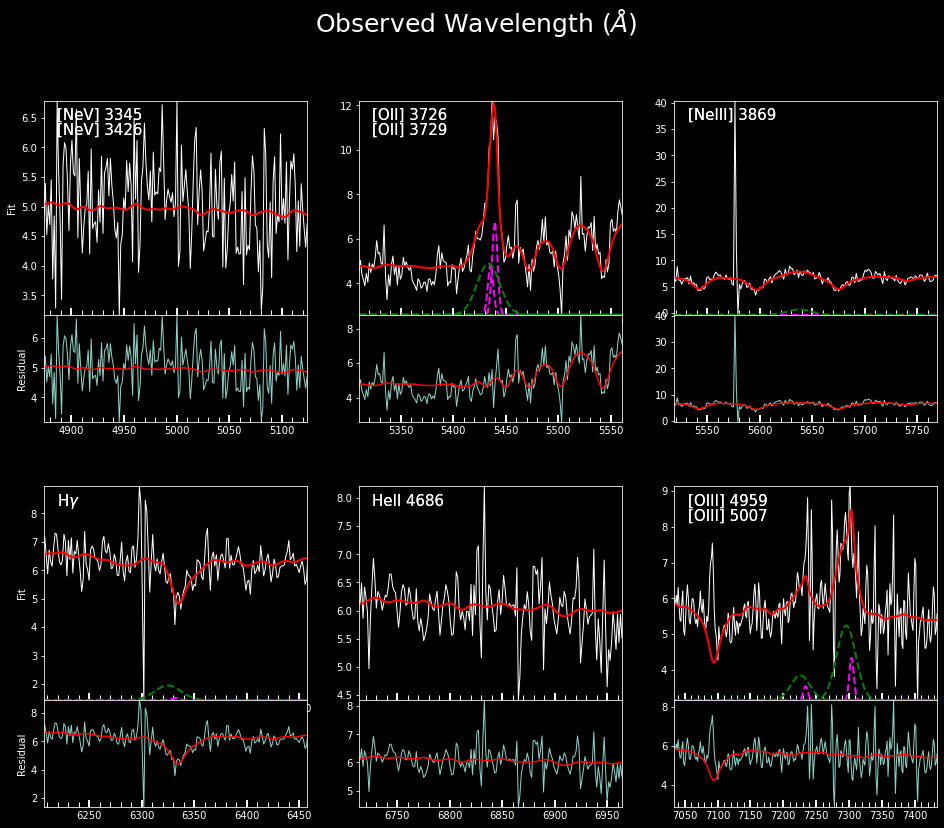

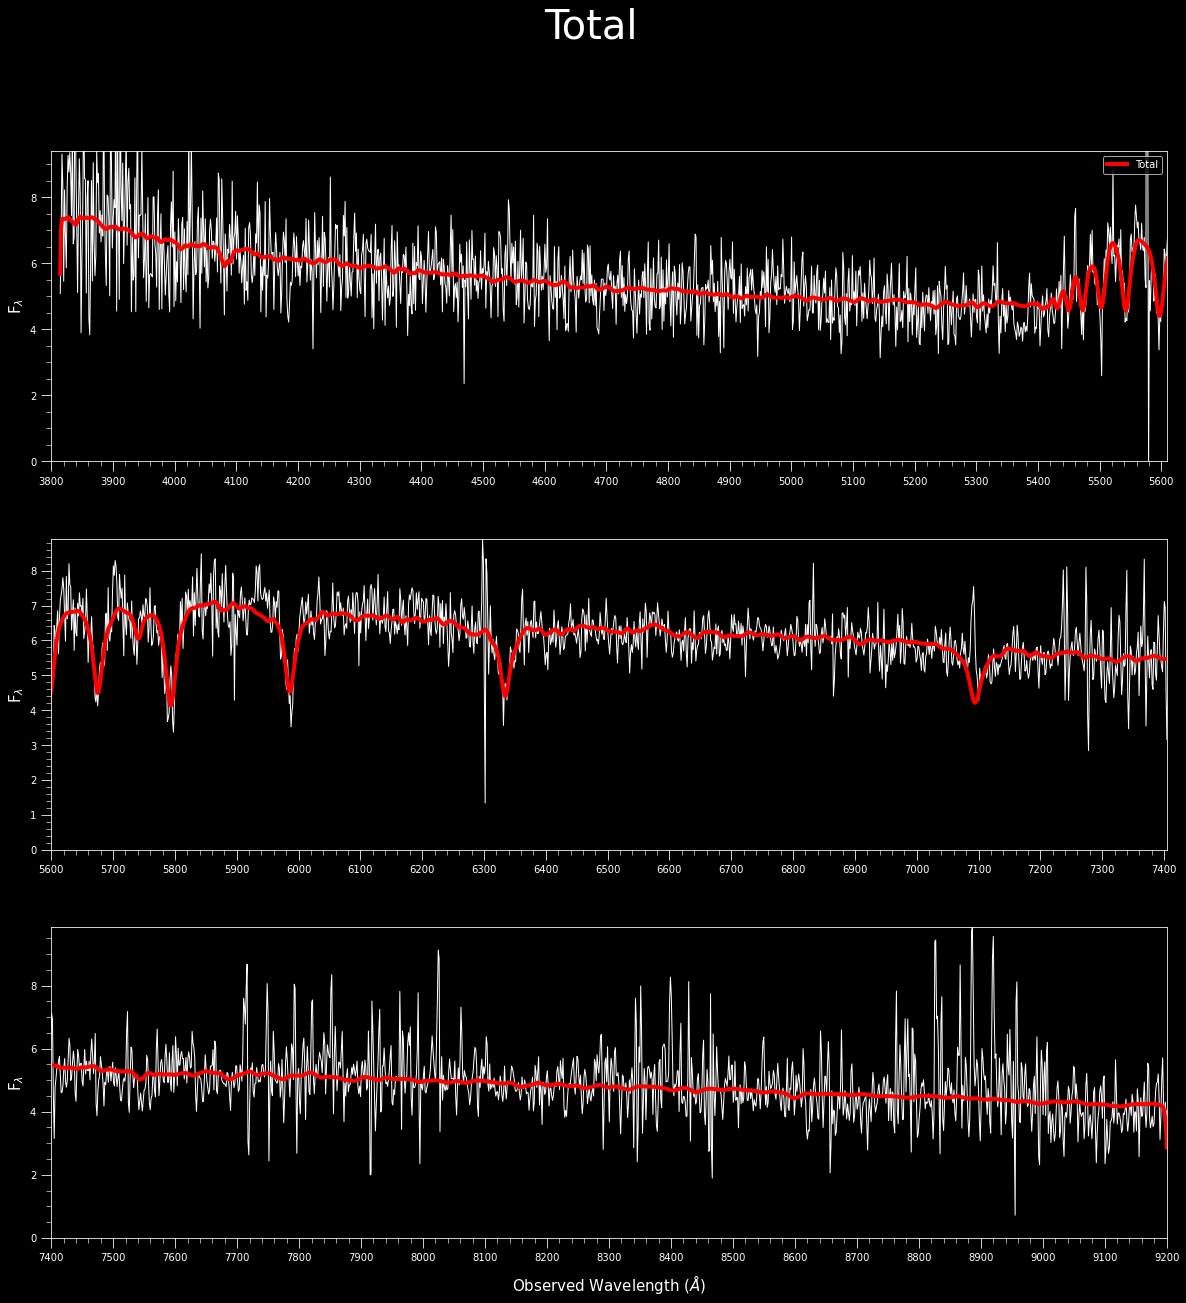

In [11]:
%matplotlib inline
q3da(initproc)

Plots in an external, interactive window:

In [ ]:
%matplotlib
q3da(initproc)